# Bayesian Decision Making
PyData Global 2020

If you are reading the interactive slides from binder, press `space` to move to the next slide.

# Note to those running this locally
Remove the %%capture headers to get the image outputs

In [2]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

Useful links
https://www.markroepke.me/posts/2019/06/05/tips-for-slideshows-in-jupyter.html

Decisions are everywhere, from deciding what to wear given a weather forecast each day to deciding how much inventory to hold in a multi million dollar supply chain. What is certain is that tools in the PyData ecosystem can help you, or your business, make those decisions with more confidence. Its called decision science in this talk we'll cover what it is and how to use it.

## Outline

The talk will be presented in a way that will not require deep knowledge of any of the technical topics, but just an intuition of basic supply, demand, and multiplication. The intent of the talk is to show how the modern computational tools can be used to make more informed decisions and affect change in common business, or even personal life, scenarios

### Introduction
   * Decisions are everywhere
   * Data is now everywhere is well
   * Data informed decisions not so much

### Decisions from summary analysis
   * This is what most businesses do using Excel or Tableau
        *Nothing wrong with this approach. Its quick and reliable and most folks have the skillset
   * While data focused the approach leads itself to human bias
   *  Leaves information on the table
   * Not very reproducible
   * Doesn't scale to many dimensions
   * We can do better

### Loss/Cost/Reward/Utility Functions

    * Taking an idea from Game Theory different versions of the future will have different goodness
    * This lets us determine how much reward we'll get for different actions

### Quantifying Uncertainty

   * Bayesian Methods let us predict the future, not just summarize the past
   * Not just one future though but all futures
   * Particularly well suited to explaining why its predictions are the way they are

### Optimizing over all possible futures

    * Given a distribution of possible futures and a cost function we can optimize to pick an action that will most likely result in the best outcome
    * Open Source code makes it really easy these days!


Technical Summary of talk
I'll be presenting most likely using Jupyter slides. The analysis will cover a little bit of supply chain theory in math form, and then a whole bunch of simulated supply chain theory in usings scipy.stats.(random) methods, PyMC3 or Stan for parameter estimation, more scipy for optimization methods, matplotlib for plotting. Of course numpy and pandas will likely be in there somewhere as well.

# Who Am I

* Ravin Kumar
* Data Scientist, Supply Chain Engineer, Bayesian Statistician (Depending on who's asking)
* Twitter and github: canyon289

# What I used to do

## Develop supply chain systems for building machinery like Drill Ships
![DrillShip](img/DrillShip.png)

# What I used to do

## Use statistics and python to make make rocket ships

![FalconHeavy](img/FalconHeavy.png)

# What I used to do

## Utilize the PyData Stack to optimize salad manufacturing

![Sweetgreen](img/Sweetgreen.png)

# What I do now

## Core Contributor for PyMC3 and ArviZ

Insert Picture

# Agenda
* Decisions are everywhere
* Lets talk about newsvendors and the difficult decisions they have to make
* How math can help newsvendors
   * Classical Approach
   * (Lack of) extensibility to reality in this approach
   * Modern approach
* What you can do to get started

# Businesses need to make decisions
Data is optional. The decisions are not
<center><img src="img/BusinessOutcomes.png" alt="Drawing" style="height: 500px;"/> </center>


# Types of decisions

Small stakes, high volume (Ad buys, Minutes until ride share)

Strategic decisions, Outcomes are highly consequential


# Lets talk about selling newspapers

## Anisha sells newspapers. 

* She buys them wholesale for 5 dollars and sells then for 7 dollars. 
* Newpapers only last one day, they become worthless the next day. 
* Each morning she must make a choice of how many to purchase. 
* If she buys too little she loses an opportunity, if she buys too many she wastes money on unsold papers. 

For her this is a big decision. She won't get a lot of tries before going out of business. How many should she purchase in the morning to **maximize her profit**?

# Each decision has an expected outcome (or multiple)
Not always the one you want

Data is optional. The decisions are not
<center><img src="img/BusinessOutcomes.png" alt="Drawing" style="height: 500px;"/> </center>

# How can we get the best outcome using math to help?
Goal is to maximize profit. To maximize something with numbers we need to describe it in math

# Profit Calculation
If we know

1. Cost of goods sold, acronym COGS (The price Anisha buys for)
2. The end consumers price (The price Anisha sells for)
3. The demand for the day
4. **Anisha's decision**: *The number of newspapers Anisha decides to buy*

If we know all of those we can directly calculate Anisha's profit.  

*Note* In the simplest version of this problem we do not account for lost sales, just the transactions that did occur

# Decision 1. Anisha buys 42 newspapers
Let' assume the demand is 40 newspapers

In [3]:
newspaper_cost = 5
customer_price = 7

# We c
anishas_inventory = 42
demand = 40

profit = demand*customer_price - newspaper_cost*anishas_inventory

f"Anisha makes ${profit} in profit"

'Anisha makes $70 in profit'

# Decision 2. Anisha buys 38 newspapers
The demand is 40 newspapers but Anisha can only sell as many as she bought

In [4]:
newspaper_cost = 5
customer_price = 7
anishas_inventory = 38

# Anisha can't sell more news papers than she can buy so she sells out
profit = anishas_inventory*customer_price - newspaper_cost*anishas_inventory
f"Anisha makes ${profit} in profit"

'Anisha makes $76 in profit'

# Let's write make express this in a python formula

In [83]:
def profit_calculator(inventory, demand, cogs=5, price=7):
    """Loss function for unmet demand"""
    profit_per_sale = price-cogs
    if demand < inventory:
        leftover_product = inventory-demand
        
        # I'm unhappy because I lost money on unsold inventory
        utility = demand*profit_per_sale - leftover_product * cogs
    
    if demand >= inventory:        
        # I'm unhappy because I could have sold more newspapers
        utility =  inventory*profit_per_sale 
        
    return utility

In [84]:
f"Decision 1: profit ${profit_calculator(42, 40)}, Decision 2 profit ${profit_calculator(38, 40)}"

'Decision 1: profit $70, Decision 2 profit $76'

# Since this is pydata let's make use pydata tools!
This function is equivalent to the one above

In [85]:
def daily_profit(inventory, demand, newsvendor_cost=5, customer_price=7):
    """Calculates  
    profit for a given day given inventory and demand"""
    return customer_price*np.min([inventory, demand]) - newsvendor_cost*inventory

In [86]:
f"Decision 1: profit ${daily_profit(42, 40)}, Decision 2 profit ${daily_profit(38, 40)}"

'Decision 1: profit $70, Decision 2 profit $76'

In [91]:
%%capture
choices_anisha_could_make = list(range(100))
profit_with_each_choice = [profit_calculator(inv, 40) for inv in choices_anisha_could_make]

fig, ax=plt.subplots(figsize=(10,6))
ax.plot(choices_anisha_could_make, profit_with_each_choice)
ax.axvline(40, linestyle='--', c="gray")
ax.set_xlabel("Number of Newspaper Anisha Bought")
ax.set_title(("Amount of profit Anisha makes in Dollars if demand is fixed at 40 Units \n"
              "Rapid dropoff is because Anisha makes 2 dollars on each paper sold \n"
              "but loses 5 dollars on each unsold")
            )
fig.savefig("img/ProfitCurve.png")

#### Generating a profit curve for a range of possible decisions
A plot of profit at the possible choices from 0 to a 100, assuming fixed demand of 40

In [93]:
choices_anisha_could_make = list(range(100))
profit_with_each_choice = [profit_calculator(inv, 40) for inv in choices_anisha_could_make];

![ProfitCurve](img/ProfitCurve.png)

# Optimal Decision given fixed demand
If we know demand is 40 newspapers a day, well then the obvious thing to do is buy 40 newspapers in the morning. We can see this in the plot No data science needed!!

*Insert picture of pydata logo x out*

# But lets run an optimizer just to double check
I mean scipy makes it so so easy. Thanks scipy!

### Define an objective function that takes an array and minimization target
Note: We need to turn this into a minimization target so we flip the sign

In [40]:
def objective(inventory: int, demands: iter):
    """Takes an iterable of sales and returns the total profit"""
    print(f"Testing inventory value {inventory} with demands array {demands}")
    # Make reward function negative to turn this into a minimization problem
    return -np.sum([daily_profit(inventory, d) for d in demands])

# Optimizer run

In [41]:
# Let scipy find minimie objective function (negative profit) if demands is set to 40
kwargs = {"demands":[40]}
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=([40]))
opt_stoch

Testing inventory value 0.0 with demands array [40]
Testing inventory value 1.0 with demands array [40]
Testing inventory value 2.6180339999999998 with demands array [40]
Testing inventory value 178.98373999999998 with demands array [40]
Testing inventory value 2.6180339999999998 with demands array [40]
Testing inventory value 69.983737257996 with demands array [40]
Testing inventory value 28.3494422106437 with demands array [40]
Testing inventory value 28.84680861337978 with demands array [40]
Testing inventory value 44.55971670004926 with demands array [40]
Testing inventory value 36.578275115766075 with demands array [40]
Testing inventory value 36.641722628043496 with demands array [40]
Testing inventory value 39.66612715175125 with demands array [40]
Testing inventory value 41.53531197715645 with demands array [40]
Testing inventory value 38.510907453448695 with demands array [40]
Testing inventory value 40.38009220277197 with demands array [40]
Testing inventory value 39.59009957

     fun: -79.99999908867545
    nfev: 43
     nit: 38
 success: True
       x: 40.00000018226491

In [97]:
# Restating here so future slides won't have the print
def objective(inventory: int, demands: iter):
    """Takes an iterable of sales and returns the total profit"""
    # Make reward function negative to turn this into a minimization problem
    return -np.sum([daily_profit(inventory, d) for d in demands])

# What if demand is not fixed
Life is harder, both for the data people and the decision people
<center><img src="img/BusinessOutcomes.png" alt="Drawing" style="height: 500px;"/> </center>

# The challenge is matching the expectation to reality with uncertainty
Easy when things are fixed, harder when things are uncertain

# What is the optimal decision given variable demand?
Let's  say we have 5 days of demand data.

In [10]:
np.random.seed(seed=0)
random_seeds = [1,2,3,4,5]
demand = np.round(stats.norm(40, 20).rvs(15))
demand_seen, demand_unseen = demand[:5], demand[5:]

In [11]:
f"The first five days demand we have seen {demand_seen}"

'The first five days demand we have seen [75. 48. 60. 85. 77.]'

In [12]:
f"The UNSEEN next ten days of demand {demand_unseen}"

'The UNSEEN next ten days of demand [20. 59. 37. 38. 48. 43. 69. 55. 42. 49.]'

## Methodology 1: Use the mean of the observed data
Take the average of seen demand and use that

In [98]:
mean_demand = demand_seen.mean()
f"The mean demand is {mean_demand} newspapers"

'The mean demand is 69.0'

In [100]:
objective_func_value = objective(inventory=mean_demand, demands=demand_unseen)
f"Testing choice over unseen days yield {objective_func_value} units. Lower is better"

'Testing choice over unseen days yield 230.0 units. Lower is better'

# Pros and cons of mean demand
### Pros
* Simple to implement
* Simple to explain
* Averages are supported basically (Excel, SQL, Python) and computationally scalable

### Cons
* Does not use profit and cost per newspaper to determine optimal inventory
* Does not consider variability in demand
* No principled mechanism to consider business experience

## Methodology 2: Assume demand comes from FIXED distribution with known parameters
This is quite the mouthful. In short it means
1. Assume that demand follows a parameteric distribution curve. This could be
    * A uniform distribution
    * Guassian/Normal Distribution
    * Lognormal


## If we do we can use the critical fractile equation
Assume that demand is generated from a fixed distribution. Well things are easy, just if we know the mean and standard deviatoin we plug it into this formula and we'll get the optimal answer. Mathematically guaranteed

![CriticalFractile](img/CriticalFractile.png)

##  Assumption 1: Demand is normally distributed

![CriticalFractileNormal](img/CriticalFractileNormal.png)

## Assumption 2: We can get the mean and standard deviation
The critical fractile equation is only optimal if we know the true mean and standard deviation of the demand generating distribution. We don't have those but we can estimate them from our `demand_seen` array

In [117]:
demand_mean, demand_std  = demand_seen.mean(), demand_seen.std()
f"Assuming Normal demand distribution the mean demand {demand_mean}  with Standard Deviation {demand_std} newspapers"

'Assuming Normal demand distribution the mean demand 69.0  with Standard Deviation 13.251415018781957 newspapers'

## With those two assumptions let's use our formula
In this model the fractile_inventory is the optimal inventory number. We use the objective function to compare to our earlier method

In [112]:
fractile_inventory = demand_seen.mean()+demand_seen.std()*stats.norm.ppf((7-5)/7)
objective_func_value = objective(inventory=fractile_inventory, demands=demand_unseen)

f"Testing inventory choice {fractile_inventory} over unseen days yields {objective_func_value} units. Lower is better"

'Testing inventory choice 61.5003772811769 over unseen days yields -92.48377690939299 units. Lower is better'

# Pros and cons of critical fractile method
### Pros
* Uses profit and cost per newspaper to determine optimal inventory
* Considers variability in demand
* It is mathematically *is* most optimal method if we know 
* Simple to understand and use

### Cons
* No mechanism to consider business experience
* No way to tell what true parameters are
* Choice of distribution is subjective

## Let's use bayes theorem
* Decide on our likelihood function. We'll use the normal distribution again
* Choose our priors (We'll come back to this)

In [118]:
import pymc3 as pm

with pm.Model() as newsvendor:
    sd = pm.HalfStudentT("standard_deviation_of_newspaper_demand", sigma=10, nu=20)
    mu = pm.Normal("mean_of_newspaper_demand", demand_seen.mean(), 20)
    sales = pm.Normal("demand", mu=mu, sd=sd, observed = demand_seen)

    trace = pm.sample(tune=5000, draws=10000, chains=2)
    posterior_predictive = pm.sample_posterior_predictive(trace, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean_of_newspaper_demand, standard_deviation_of_newspaper_demand]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 28 seconds.


## What we get: Estimates of Mean and Standard deviation of demand distribution

/Users/canyon/.miniconda3/envs/pydata/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


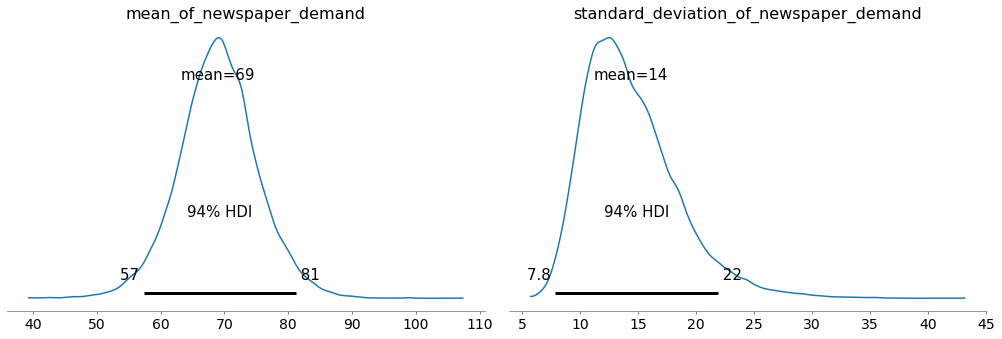

In [116]:
az.plot_posterior(trace);

## What we get: Estimates of future demand per day (Posterior Predictive)

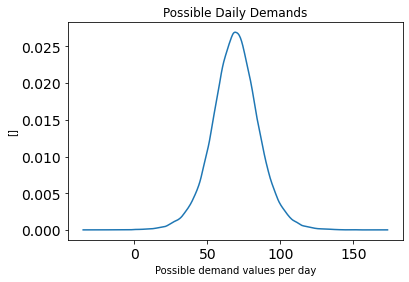

In [126]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictive["demand"].flatten(), ax=ax)
ax.set_title("Possible Daily Demands")
ax.set_ylabel([])
ax.set_xlabel("Possible demand values per day");

## Let's optimize over all versions of the future
Let's use our optimizer in conjunction with our objective function to find the optiomal *inventory holding choice* given *all possible daily demands*

In [128]:
from scipy import optimize
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=(bayesian_demand_estimate,))

In [133]:
bayes_opt = opt_stoch.x
f"Optimal inventory from Bayesian demand estimation and optimizer is {bayes_opt} newspapers"

'Optimal inventory from Bayesian demand estimation and optimizer is 60.553182905843975 newspapers'

In [137]:
objective_func_value = objective(opt_stoch.x, demand_unseen)
f"Testing inventory choice over unseen days yields {objective_func_value} units. Lower is better"

'Testing inventory choice over unseen days yields -133.21313504870926 units. Lower is better'

## So is the 